In [1]:
%matplotlib inline
import kornia
import torch
import numpy as np
import cv2
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt

In [2]:
#Lets define a function to detect a region-of-interest for a fast-moving object
def fmo_detect_maxarea(I,B):
    ## simulate FMO detector -> find approximate location of FMO
    dI = (np.sum(np.abs(I-B),2) > 0.03).astype(float)
    labeled = label(dI)
    regions = regionprops(labeled)
    ind = -1
    maxarea = 0
    for ki in range(len(regions)):
        if regions[ki].area > maxarea:
            ind = ki
            maxarea = regions[ki].area
    if ind == -1:
        return [], 0
    bbox = np.array(regions[ind].bbox).astype(int)
    return bbox, regions[ind].minor_axis_length

In [3]:
#Also, we will need several helper functions
def extend_bbox(bbox,ext,aspect_ratio,shp):
    height, width = bbox[2] - bbox[0], bbox[3] - bbox[1]
    h2 = height + ext
    h2 = int(np.ceil(np.ceil(h2 / aspect_ratio) * aspect_ratio))
    w2 = int(h2 / aspect_ratio)
    wdiff = w2 - width
    wdiff2 = int(np.round(wdiff/2))
    hdiff = h2 - height
    hdiff2 = int(np.round(hdiff/2))
    bbox[0] -= hdiff2
    bbox[2] += hdiff-hdiff2
    bbox[1] -= wdiff2
    bbox[3] += wdiff-wdiff2
    bbox[bbox < 0] = 0
    bbox[2] = np.min([bbox[2], shp[0]-1])
    bbox[3] = np.min([bbox[3], shp[1]-1])
    return bbox

def crop_resize(Is, bbox, res):
    return cv2.resize(Is[bbox[0]:bbox[2], bbox[1]:bbox[3]], res, interpolation = cv2.INTER_CUBIC)

def rev_crop_resize(inp, bbox, I):
    est_hs = np.tile(I.copy()[:,:,:,np.newaxis],(1,1,1,inp.shape[3]))
    for hsk in range(inp.shape[3]):
        est_hs[bbox[0]:bbox[2], bbox[1]:bbox[3],:,hsk] = cv2.resize(inp[:,:,:,hsk], (bbox[3]-bbox[1],bbox[2]-bbox[0]), interpolation = cv2.INTER_CUBIC)
    return est_hs

def rgba2hs(rgba, bgr):
    return rgba[:,:,:3]*rgba[:,:,3:] + bgr[:,:,:,None]*(1-rgba[:,:,3:])

In [4]:
#We define a simplified function for using DeFMO
def run_defmo(I, B, defmo, device):
    resolution_x = 320; resolution_y = 240
    bbox, radius = fmo_detect_maxarea(I,B)
    bbox = extend_bbox(bbox.copy(),4*np.max(radius),resolution_y/resolution_x,I.shape)
    im_crop = crop_resize(I, bbox, (resolution_x, resolution_y))
    bgr_crop = crop_resize(B, bbox, (resolution_x, resolution_y))
    input_batch = torch.cat((torch.Tensor(im_crop), torch.Tensor(bgr_crop)), 2).permute(2,0,1).to(device).unsqueeze(0).float()
    renders = defmo(input_batch)
    renders_rgba = renders[0].data.cpu().detach().numpy().transpose(2,3,1,0)
    tsr_crop = rgba2hs(renders_rgba, bgr_crop)
    tsr = rev_crop_resize(tsr_crop,bbox,B.copy())
    tsr[tsr > 1] = 1
    tsr[tsr < 0] = 0
    return tsr

In [5]:
#Now, let's initialize DeFMO
device = torch.device("cuda:{}".format(0) if torch.cuda.is_available() else "cpu") 
defmo = kornia.feature.DeFMO(pretrained = True).to(device)
defmo.train(False)
print(device)

cuda:0


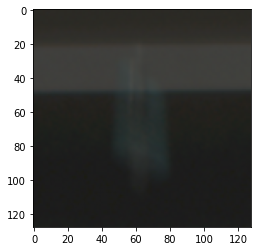

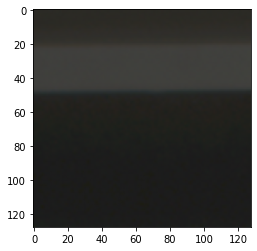

In [6]:
#Let's read an image with a highly blurred object and its background
I = cv2.imread("img/im.png", cv2.IMREAD_UNCHANGED)[:,:,[2,1,0]]/255
B = cv2.imread("img/bgr.png", cv2.IMREAD_UNCHANGED)[:,:,[2,1,0]]/255
bbox, radius = fmo_detect_maxarea(I,B)
bbox = extend_bbox(bbox.copy(),1*np.max(radius),1,I.shape)
im_crop = crop_resize(I, bbox, (128, 128))
bgr_crop = crop_resize(B, bbox, (128, 128))
plt.imshow(im_crop)
plt.figure()
plt.imshow(bgr_crop)

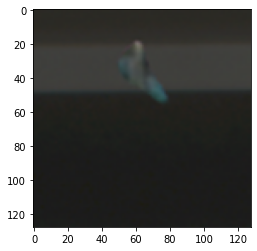

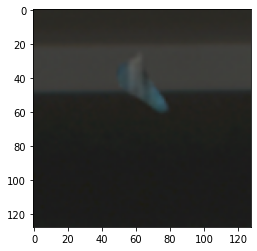

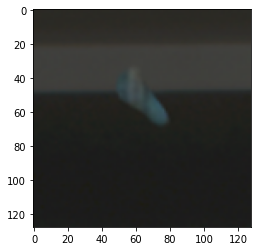

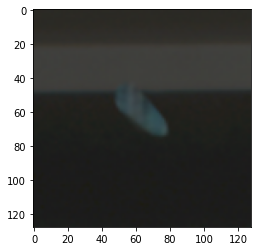

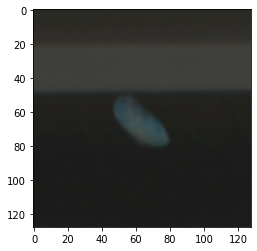

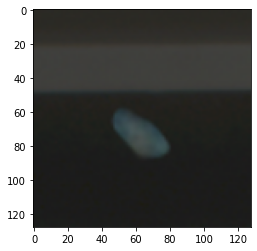

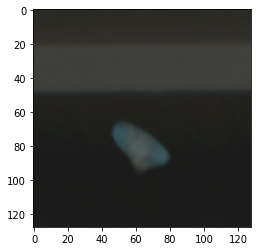

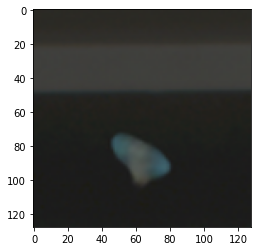

In [7]:
#and run DeFMO
tsr = run_defmo(I,B, defmo, device)
#and visualize the results
for ki in range(tsr.shape[-1]): 
    if ki % 3 != 0:
        continue
    plt.figure()
    tsr_crop = crop_resize((tsr[:,:,:,ki] * 255).astype(np.uint8), bbox, (128, 128))
    plt.imshow(tsr_crop)
plt.show()


In [8]:
#Now, let's define a general wrapper to process two images (input and background) or a video
def defmo_wrapper(im_path, bgr_path):
    I = cv2.imread(im_path, cv2.IMREAD_UNCHANGED)[:,:,[2,1,0]]/255
    B = cv2.imread(bgr_path, cv2.IMREAD_UNCHANGED)[:,:,[2,1,0]]/255
    tsr = run_defmo(I,B, defmo, device)
    out = cv2.VideoWriter('im_tsr.avi',cv2.VideoWriter_fourcc(*"MJPG"), 6, (I.shape[1], I.shape[0]),True)
    for ki in range(tsr.shape[-1]): out.write( (tsr[:,:,[2,1,0],ki] * 255).astype(np.uint8) )
    out.release()
def run_video(video_path, defmo, device):
    median = 7
    Ims = []
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        Ims.append(frame)
        if len(Ims) >= median:
            break
    B = np.median(np.asarray(Ims)/255, 0)[:,:,[2,1,0]]

    out = cv2.VideoWriter('tsr.avi',cv2.VideoWriter_fourcc(*"MJPG"), 6, (B.shape[1], B.shape[0]),True)
    tsr0 = None
    frmi = 0
    median = len(Ims)
    while cap.isOpened():
        if frmi < median:
            frame = Ims[frmi]
        else:
            ret, frame = cap.read()
            if not ret:
                break
            Ims = Ims[1:]
            Ims.append(frame)
            ## update background (running median)
            B = np.median(np.asarray(Ims)/255, 0)[:,:,[2,1,0]]
        frmi += 1
        I = frame[:,:,[2,1,0]]/255
        tsr = run_defmo(I, B, defmo, device)
        if frmi == 1:
            tsr0 = tsr
            continue
        if frmi == 2:
            forward = np.min([np.mean((tsr0[...,-1] - tsr[...,-1])**2), np.mean((tsr0[...,-1] - tsr[...,0])**2)])
            backward = np.min([np.mean((tsr0[...,0] - tsr[...,-1])**2), np.mean((tsr0[...,0] - tsr[...,0])**2)])
            if backward < forward:
                ## reverse time direction for better alignment
                tsr0 = tsr0[...,::-1]
            for ki in range(tsr.shape[-1]):
                out.write( (tsr0[:,:,[2,1,0],ki] * 255).astype(np.uint8) )

        if np.mean((tsr0[...,-1] - tsr[...,-1])**2) <  np.mean((tsr0[...,-1] - tsr[...,0])**2):
            ## reverse time direction for better alignment
            tsr = tsr[...,::-1]

        for ki in range(tsr.shape[-1]):
            out.write( (tsr[:,:,[2,1,0],ki] * 255).astype(np.uint8) )
        tsr0 = tsr              
    cap.release()
    out.release()

In [9]:
#Now, we can run DeFMO on custom images or videos, including the famous UFO example
defmo_wrapper("img/im.png", "img/bgr.png")
run_video("imgs/falling_pen.avi", defmo, device)
run_video("imgs/ufo_im%01d.png", defmo, device)